# **Auswertung der Energieverbrauchsmessung**
___

In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime as dt
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from src.project_definitions import BUID, AREA, WOHNUNGEN, ROOMS, dir_results, area
from src.utilities import recolor_lines, export, truncate_colormap, DIN, eb_bbox
from src.sensor_reader import IND, AMB, EM

plt.style.use(".\src\stylesheets\eb3.mplstyle")

import locale
locale.setlocale(locale.LC_ALL,'de_DE')

ex  = False

exdir = os.path.join(dir_results,'Energiebedarf')
if not os.path.isdir(exdir):
    os.makedirs(exdir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## User Inputs:

1. ``Heiztage``:
Eingabe der Heiztage für den Standort Bad Aibling unter der Bedingung < 15 °C bzw. < 12 °C. Die aktuellen Werte basieren auf dem Datensatz TRY2017_Mietraching_extrem.

2. Auswahl Heiztag-Grenztemperatur `ht`: Auswahl welcher Grenzwert für die Berechnung der Heiztage verwendet werden soll. 

3. ``dK``: Temperaturdifferenz zwischen Heizkörper und Raumluft, ab der davon ausgegangen wird, dass die Heizung aufgedreht ist.

4. Graphen abspeichern: Wenn: `'ex' = True` werden die Graphen im Output Ordner abgespeichert.

In [33]:
#########################################################____INPUT____#############################################################################
# Tage mit mittlerer Außentemperatur < 15 bzw. 12°C. Wetterdatensatz TRY2017_Mietraching_extrem
Heiztage = {'15':266,'12':211}

ht  = '12'
dK  = 1


In [34]:
def ax_layout(ax,_title,_ylabel,_unit,_cmap = None, days = None, _ylim=None):
    for il, line in enumerate(ax.lines):
        df = pd.DataFrame(zip(line.get_xdata(),line.get_ydata()))
        df.columns = ['Datetime','Value']
        df.set_index('Datetime',inplace=True)
        if il % 2 == 0: il=1
        else: il = -1
        ax.annotate(
            f'{round(float(df.loc[df.index.max()]),1)}{_unit}',
            xy=(df.index.max(), df.loc[df.index.max()]), 
            xycoords='data',
            xytext=(20, -il*10), 
            textcoords='offset points',
            horizontalalignment='left', 
            verticalalignment='center',
            arrowprops=dict(arrowstyle="-",
                color="0.5",
                shrinkB=5,
                connectionstyle="arc3,rad=0.3"),
            )
    if _cmap:
        recolor_lines(ax,_cmap, 0.2, 1)
        
    ax.legend(loc='upper left',ncol=99,bbox_to_anchor=(0.025, 1.025, 1, 0.05),frameon=False)

    deltat = df.index.max()-df.index.min()
    ax.xaxis.set_major_locator(mpl.dates.HourLocator([0]))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%a,\n%d.%m.'))

    if deltat <= dt.timedelta(14):    
        ax.xaxis.set_minor_locator(mpl.dates.HourLocator([12]))
        ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%H:%M h'))
    else: 
        ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %Y'))
    if days:
        ax.set_xlim((dt.datetime.now()-dt.timedelta(days)),(dt.datetime.now()+dt.timedelta(0.5)))
    ax.grid(False)


    
    #ax.set_title(_title,loc='left')
    ax.text(0.025, 1.09,_title, fontweight = 'bold', fontsize = 8, ha = 'left', va = 'top', transform=ax.transAxes,)
    if _ylim:
        ax.set_ylim(_ylim)
    ax.set_ylabel(_ylabel)

## **Energieverbrauch**

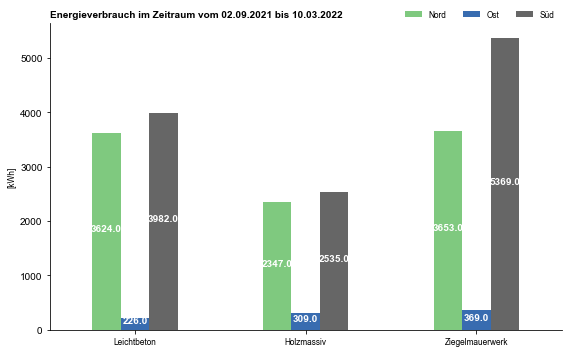

In [35]:
idx = pd.IndexSlice
df = EM.loc(axis=1)[idx[:, ["N", "O", 'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.resample('365d').last() - df.resample('365d').first()
df.reset_index(drop=True).round(2)
fig,ax = plt.subplots(figsize=(8,5))
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Energieverbrauch im Zeitraum vom {(EM.index.min().strftime("%d.%m.%Y"))} bis {EM.index.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),1),
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch',extlist=['pdf'], show=True)

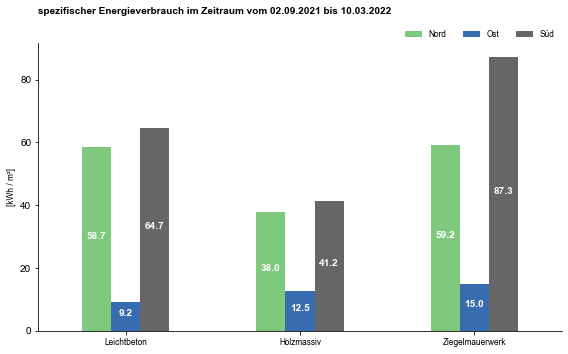

In [36]:
idx = pd.IndexSlice
df = EM.loc(axis=1)[idx[:, ["N", "O",'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.resample('365d').last() - df.resample('365d').first()
df = df.reset_index(drop=True).div(AREA,level=1).round(2)
fig,ax = plt.subplots(figsize=(8,5))
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'spezifischer Energieverbrauch im Zeitraum vom {(EM.index.min().strftime("%d.%m.%Y"))} bis {EM.index.max().strftime("%d.%m.%Y")}', fontweight = 'bold', y=1.08)
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),1),
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'spezifischer_Wärmeenergieverbrauch',extlist=['pdf'], show=True)

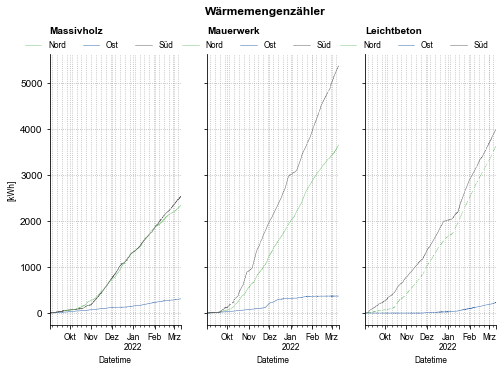

In [37]:
fig, axs = plt.subplots(1,3,sharex=True, sharey=True,figsize=(8,5))
fig.suptitle(f'Wärmemengenzähler',y=1.01)
for b, bui in enumerate(BUID):
    df = EM.loc(axis=1)[idx[bui,['N','O','S'],'HQ','H']].droplevel([0,2,3],axis=1).resample('H').last()
    (df - df.min()).plot(ax=axs[b], cmap = 'Accent')
    axs[b].legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
    axs[b].set_title(f'{BUID[bui]}',y=1.05)
axs[0].set_ylabel(f'[kWh]')
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch_kumuliert',extlist=['pdf'], show=True)

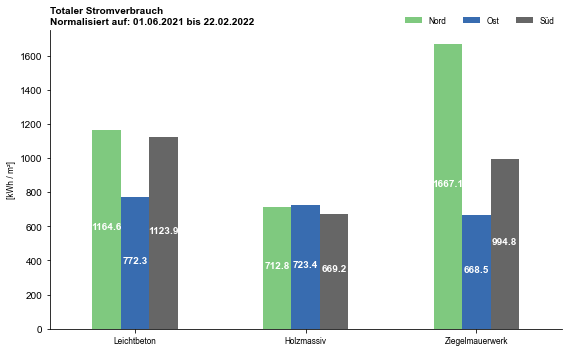

In [38]:
Normalize = True
Spezifisch = False

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,6,1)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

if Spezifisch:
    df = df.reset_index(drop=True).div(AREA,level=1).round(2)
    title = 'Spezifischer Stromverbrauch'
else:
    title = 'Totaler Stromverbrauch'
    
df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=(8,5))
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    ax.set_title(f'{title}\nNormalisiert auf: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),1),
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'Stromverbrauch_spezifisch',extlist=['pdf'], show=True)

## **Auswertung des täglichen Energieverbrauchs der einzelnen Wohneinheiten:**
___
Bei dieser Auswertung werden oben die mittleren Temperaturen pro Wohnung und getrennt nach Heizkörper- und Lufttemperaturtemperaturen aufgetragen. Der Mittelwert wird dabei über alle Heizkörpersensoren ``pt_Thk``, bzw. über alle Raumluftsensoren ``trh_Tair`` einer Wohnung ermittelt.

Im unteren Graph wird der aufgezeichnete Energieverbrauch, gemittelt über die letzten 24h aufgetragen. Der graue Bereich, stellt den Zeitraum dar, in dem die gemittelte Heizkörpertemperatur um den Wert ``dK`` höher ist als die gemittelte Raumlufttemperatur. In diesem Zeitraum wird die Heizung als 'an' definiert.
___

plotting Massivholz...


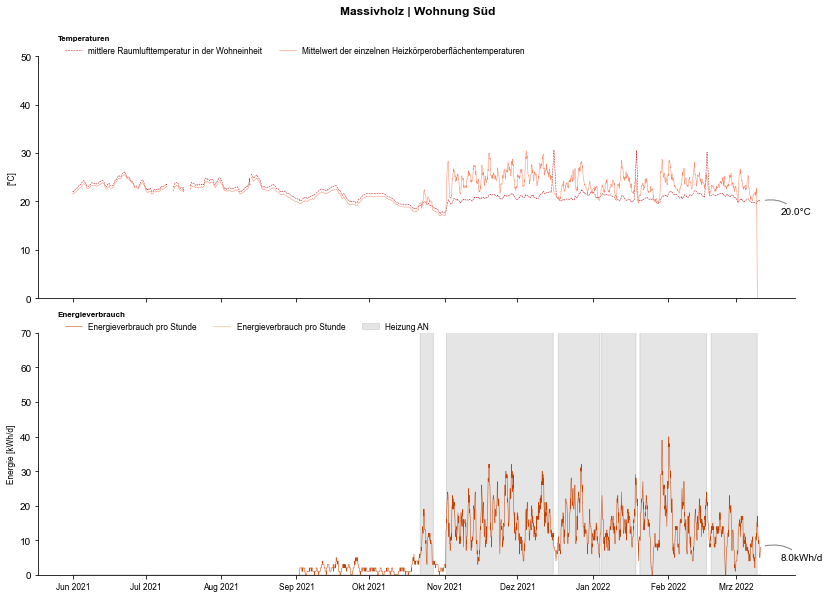

In [39]:
sums = {}
tset = 22

if ex: 
    _BUID = BUID
    _wohnungen = WOHNUNGEN
else: 
    _BUID = ['MH']
    _wohnungen = ['S']
    
for bui in _BUID:
    if bui not in sums: sums[bui] = {}
    print(f'plotting {BUID[bui]}...')
    for app in _wohnungen:
        fig, axs = plt.subplots(2,1,figsize=DIN['A4L'],sharex=True)
        trh = IND[bui][app].filter(like='trh_Tair').rolling('D').mean().mean(axis=1)
        thk = IND[bui][app].filter(like='Thk').rolling('D').mean().mean(axis=1)
        heat = pd.DataFrame({'On/Off': trh.round(1) <= thk.round(1)})
        deltaT = pd.DataFrame({'deltaT': thk-trh})   
        
        axs[0].plot(trh, ls = 'dashed', label = 'mittlere Raumlufttemperatur in der Wohneinheit')
        axs[0].plot(thk, label = 'Mittelwert der einzelnen Heizkörperoberflächentemperaturen')
        ax_layout(axs[0], 'Temperaturen', '[°C]', '°C', 'Reds_r',_ylim=(0,50))

        axs[1].plot(EM[bui][app]['HQ'].resample('H').last().diff().rolling('D').sum(), label = 'Energieverbrauch pro Stunde')
        axs[1].fill_between(x=heat.index, y1=(deltaT.rolling('D').mean() > 0).deltaT*1000,alpha=0.1,color='k',label=f'Heizung AN')
        ax_layout(axs[1], 'Energieverbrauch', 'Energie [kWh/d]', 'kWh/d','Oranges_r',_ylim=(0,70))
        
        fig.suptitle(f'{BUID[bui]} | Wohnung {WOHNUNGEN[app]}',y=1)
        fig.tight_layout()

    if ex:
        export(fig,os.path.join(dir_results,'Energiebedarf'),f'{bui}_Energieverbrauch+Temperaturen',['pdf'],show=True)

## **Hochrechnung des spezifischen Heizenergiebedarfs**
In den folgenden Graphen wird ein spezifischer Heizenergiebedarf auf ein gesamtes Jahr extrapoliert. Dabei wird auf Raumebene definiert, ob dieser Raum gerade beheizt wird. Die Heizung wird als 'An' definiert, wenn die gemessene Heizkörpertemperatur mindestens um den Wert ``dK`` höher ist als die gemessene Raumlufttemperatur. 

Aus den ermittelten Werten wird ein mittlerer Energieverbrauch im Zustand Heizung 'AN' und einer für den Zustand Heizung 'AUS' ermittelt. Anhand der zu Beginn eingegeben Heiztage für den Standort wird dann ein Heizenergiebedarf auf das ganze Jahr hochgerechnet. 


> ##### ACHTUNG
> Aufgrund dieser Rechenweise wird der Energieverbrauch der unbewohnten 1-Zimmer-Appartments ("Wohnung Ost") sehr verzerrt abgebildet. Ein realistisches Bild über den Energieverbrauch dieser Wohneinheiten liefert die Verbrauchsdarstellung im Folgenden.

In [40]:
# #########################################################____Skript____#############################################################################
# heat={}
# wd = AMB.loc['2021-09':]
# T_amb_g24 = wd['T_amb'].rolling('D').mean()
# T_amb_g24[T_amb_g24<float(ht)] = 1
# T_amb_g24[T_amb_g24>=float(ht)] = 0
# for bui in BUID:
#     if bui not in heat:
#         heat[bui] = {}
#     df = EM[bui]
#     df2 = IND[bui].loc['2021-09':]
#     fig,axs = plt.subplots(3,1,figsize=din_a4_landscape)
#     fig.subplots_adjust(bottom=0.1)
#     axs2=[]
#     fig.suptitle(f'Auswertung Wärmemengenzähler\n{BUID[bui]}',fontsize='large',fontweight='bold',va='top',ha='center')
#     for i, app in enumerate(WOHNUNGEN):
#         # set axis title
#         axs[i].set_title(f'Wohnung {WOHNUNGEN[app]}',loc='left')

#         #plot Wärmemengenzähler
#         df_heatenergy = df[app].resample('H').last().dropna(how='all').fillna(method='bfill')['HQ','H'].diff().rolling('D').sum()
#         axs[i].plot(df_heatenergy, color = 'k',label='Wärmemengenzähler')

#         #mark Heiztage
#         axs[i].fill_between(T_amb_g24.index,T_amb_g24*100,alpha=0.1,color='k',label=f'Heiztag {ht}°C')

#         #plot Heizkörpertemperaturen
#         axs2.append(axs[i].twinx())
#         thk = (df2[app].filter(like='pt_Thk').rolling('D').mean()).subtract((df2[app].filter(like='trh_Tair').rolling('D').mean().mean(axis=1)),axis='index')
#         thk[thk < dK] = 0
#         for col in thk:
#             axs2[i].plot(thk[col],label = r'$\Delta T_{' +str('HK,')+ str(ROOMS[col[0]]) + '}$', linestyle='dashed',alpha=0.75)
        
#         recolor_lines(axs2[i],'Reds_r', 0, 0.8)

#         han1,lab1 = axs[i].get_legend_handles_labels()
#         han2,lab2 = axs2[i].get_legend_handles_labels()

#         axs2[i].legend(labels=lab1+lab2,handles=han1+han2,loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
#         axs2[i].set_ylabel(r'$\Delta T_{' + str('Heizkörper, Luft') + '}$ [K]',fontsize='large')
#         axs2[i].set_ylim(0,45)

#         #calculate heating demand
#         df3 = df[app].dropna(how='all').fillna(method='bfill')['HQ'].diff().rolling('D').sum()
#         df3['on_off'] = thk.max(axis=1).resample('1min').max()

#         heatoff = round(
#             (((df3[df3['on_off'] == 0.0].resample('D').last()['H'])).mean())/area[app]['sum']
#             ,2)

#         heaton = round(
#             ((df3[df3['on_off'] > 0.0].resample('D').last()['H'])).mean()/area[app]['sum']
#             ,2)

#         q_tot = round(
#             ((df3.resample('D').last()['H'])).mean()/area[app]['sum']*365
#             ,1)
    
#         approx = round(heaton*Heiztage[ht]+(365-Heiztage[ht])*heatoff,1)
        
#         heat[bui][app] = (q_tot,heatoff,heaton)

#         #Infobox
#         axs[i].text(
#                 0.05,
#                 0.95, 
#                 r"$\bf{"+str('Jahresverbrauchswerte:')+'}$\n' + 
#                 f'Heizung "AN": {heaton} '+ r'$\frac{kWh}{m^2*d}$'+ 
#                 f'\nHeizung "AUS": {heatoff} '+ r'$\frac{kWh}{m^2*d}$'+ 
#                 f'\nMittelwert: {q_tot} '+ r'$\frac{kWh}{m^2*a}$'+ 
#                 f'\nHochrechnung: {approx} '+ r'$\frac{kWh}{m^2*a}$',      
#                 fontsize = 'medium', 
#                 style='normal', 
#                 ha = 'left', 
#                 va = 'top',
#                 transform=axs[i].transAxes,
#                 bbox=eb_bbox
#                 )
    
#     # clean up axes
#     for ax in axs:
#         ax.set_ylim(0,100)
#         ax.set_ylabel('Energieverbrauch ' + r'$[\frac{Wh}{d}]$')
#         ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
#         ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %Y'))

#     stand = min(wd.index.max().round('D'),df.index.max().round('D'))-dt.timedelta(days=1)
#     stand = stand.strftime('%d.%m.%Y')

#     # footnote
#     axs[i].annotate(
#         f'Anmerkung:\nDie Heizung wird als "AN" definiert, wenn die Differenz aus Heizkörper- und Raumlufttemperatur >{dK}K ist.\n' + 
#         f'Der Heizwärmebedarf wurde anhand der gemittelten Energieverbräuche im Zustand "AN" bzw. "AUS" und den jährlichen Heiztagen ermittelt.\n' +
#         f'Die jährlichen Heiztage wurden unter der Bedingung ' + r'$T_{amb,g24} < '+ str(ht) + r'°C$' + f' aus dem Wetterdatensatz "Mietraching (extrem)" ermittelt.\n' +
#         f'Erhebungszeitraum: 01.09.2021 bis {stand}',
#         xy = (0.5, -0.2),
#         xycoords='axes fraction',
#         ha='center',
#         va="top",
#         bbox=eb_bbox
#         )
#     fig.tight_layout()

#     # if ex:
#     #     ut.export(fig,os.path.join(eb.dir_results,'Energiebedarf'),f'{bui}_Energieverbrauch',['pdf'],show=True)

Speichere die Ergebnisee der Hochrechnung als ``.csv``-Datei ab.

In [41]:
# dfheat = pd.DataFrame.from_dict({(i,j): heat[i][j] 
#                            for i in heat.keys() 
#                            for j in heat[i].keys()},
#                        orient='index')
# dfheat.columns = ('ann_mean','off_daily','on_daily')
# dfheat.index = pd.MultiIndex.from_tuples(dfheat.index.to_list())
# dfheat['ann_calc'] = dfheat['on_daily']*Heiztage[ht]+dfheat['off_daily']*(365-Heiztage[ht])

# if ex:
#     exdir = os.path.join(dir_results,'Energiebedarf')
#     if not os.path.isdir(exdir):
#         os.makedirs(exdir)
#     dfheat.to_csv(os.path.join(exdir,'auswertung_energieverbrauch.csv'))

## **Darstellung des tatsächlichen Energieverbrauchs bis dato**

In [42]:
# fig, axs = plt.subplots(figsize=(10,6))

# sums = {}
# for bui in BUID:
#     if bui not in sums: sums[bui] = []
#     for app in WOHNUNGEN:
#         sums[bui].append((EM[bui][app]['HQ']['H'].max() - EM[bui][app]['HQ']['H'].min()))
# df = pd.DataFrame.from_dict(sums,orient='index',columns=['N','S','O'])
# df = df[['N','O','S']]
# df.plot.bar(ax = axs,cmap='Accent')

# axs.set_title(f'Summierter Energieverbrauch im Beobachtungszeitraum\n({(EM[bui].index.min().strftime("%d.%m.%Y"))} bis {EM[bui].index.max().strftime("%d.%m.%Y")})', fontweight = 'bold')
# axs.set_ylabel('Energieverbrauch\n [kWh]')
# axs.set_xticklabels([ 'Holzmassiv', 'Leichtbeton','Ziegelmauerwerk'], rotation=0)

# axs.legend(labels=['Nord','Ost','Süd'],loc='upper center',frameon=False,ncol=3)
# xticks=[]
# for bar in axs.patches:
#     xticks.append(bar.get_x())

#     axs.text(
#         bar.get_x() + bar.get_width() / 2,
#         bar.get_height()*0.5 + bar.get_y(),
#         round(bar.get_height(),1),
#         ha='center',
#         color='w',
#         weight='bold',
#         )

# fig.tight_layout()

# # if ex:
# #     ut.export(fig,exdir,'Vergleich_Heizwärmeverbrauch',extlist=['pdf','png'], show=True)

## **Darstellung des hochgerechneten spezifischen Energiebedarfs pro Gebäude**
___

In [43]:
# fig, axs = plt.subplots(figsize=(10,6))
# fig.subplots_adjust(bottom=0.1)
# df = dfheat[['ann_calc']].unstack().T
# df = df[['MH','LB','MW']]
# df = df.droplevel(0)
# df.T.plot.bar(ax = axs,cmap='Accent')

# axs.set_title('Erwarteter spezifischer jährlicher Heizwärmebedarf', fontweight = 'bold')
# axs.set_ylabel('Heizwärmebedarf\n'+ r'$[\frac{kWh}{m^2*a}]$')
# axs.set_xticklabels([ 'Holzmassiv', 'Leichtbeton','Ziegelmauerwerk'], rotation=0)

# axs.legend(labels=['Nord','Ost','Süd'],loc='upper center',frameon=False,ncol=3)
# xticks=[]
# for bar in axs.patches:
#     xticks.append(bar.get_x())

#     axs.text(
#         bar.get_x() + bar.get_width() / 2,
#         bar.get_height()*0.5 + bar.get_y(),
#         round(bar.get_height(),1),
#         ha='center',
#         color='w',
#         weight='bold',
#         )
# # if ex:
# #     ut.export(fig,exdir,'Vergleich_Heizwärmebedarf_no_footnote',extlist=['pdf','png'])

# # footnote
# axs.annotate(f'Anmerkung:\nBei den dargestellten Werten handelt es sich auf eine Hochrechnung basierend auf dem\ngemittelten Energieverbrauch bei laufender Heizung und bei ausgeschalteter Heizung, gewichtet nach den Heiztagen 'r'$T_{amb,g24}$' +f'< {ht}°C.\nDie ermittelten Verbrauchswerte beinhalten die Energie für Raumwärme und Trinkwarmwasser.',
#     xy = (0.5, -0.1),
#     xycoords='axes fraction',
#     ha='center',
#     va="top",
#     bbox=eb_bbox
#     )
# # #fig.tight_layout()
# # if ex:
# #     ut.export(fig,exdir,'Vergleich_Heizwärmebedarf',extlist=['pdf','png'], show=True)

In [44]:
# def read_sim_results(var, value):
#     sim_res = pd.read_csv(os.path.join(dir_results,'Simulation',f'Energie_{var}.csv'), header = [0,1], index_col=0).T
#     sim_res = sim_res[value].unstack()
#     sim_res.columns = ['MH', 'LB', 'MW']
#     sim_res.index = pd.MultiIndex.from_tuples([(var, 'N'),(var, 'O'),(var, 'S')])
#     return sim_res

## **Vergleich der Hochrechnung mit den Simulationsergebnissen**
___

In [45]:
# res = []
# for var in ['Variante_1','Variante_2','Variante_3']:
#     res.append(read_sim_results(var,'Q_tot_ht'))
# sim = pd.concat(res).T
# var = 'Hochrechnung'
# hochrechnung = df.T
# hochrechnung.columns = pd.MultiIndex.from_tuples([(var, 'N'),(var, 'O'),(var, 'S')])
# all_variants = pd.concat([hochrechnung,sim], axis = 1)
# all_variants.T.unstack().swaplevel(0,1,axis=1).sort_index(axis=1).T.plot.bar()

In [46]:
# hochrechnung = hochrechnung.T.droplevel(0)
# for var in ['Variante_1','Variante_2','Variante_3']:
#     sim_res = read_sim_results(var, 'Q_tot_ht').droplevel(0)
#     fig, ax = plt.subplots()
#     pd.DataFrame([sim_res.unstack(), hochrechnung.unstack()],index=['Simulation','Hochrechnung']).T.plot.bar(ax=ax)
#     fig.suptitle(f'Vergleich Simulation und Hochrechung\n{var}')
#     # if ex:
#     #     ut.export(fig, os.path.join(eb.dir_results,'Simulation'),filename=f'Vergleich_Messung_{var}',extlist=['pdf','png'])

In [47]:
# fig, axs = plt.subplots(2,1, figsize= (10,6), sharey=True)
# df = dfheat[['ann_calc']].unstack().T
# df = df[['MH','LB','MW']]
# df = df.droplevel(0)
# sim_res.T.plot.bar(ax = axs[0],cmap=truncate_colormap('Accent'))
# fig.suptitle('Vergleich des Heizwärmebedarf der Bauweisen')
# axs[0].set_title(f'Simulation ({var})', fontweight = 'bold')
# axs[0].set_ylabel('Heizwärmebedarf\n'+ r'$[\frac{kWh}{m^2*a}]$')
# axs[0].set_xticklabels([ 'Holzmassiv', 'Leichtbeton','Ziegelmauerwerk'], rotation=0)

# axs[0].legend(labels=['Nord','Ost','Süd'],loc='upper center',frameon=False,ncol=3)
# xticks=[]
# for bar in axs[0].patches:
#     xticks.append(bar.get_x())

#     axs[0].text(
#         bar.get_x() + bar.get_width() / 2,
#         bar.get_height()*0.5 + bar.get_y(),
#         round(bar.get_height(),1),
#         ha='center',
#         color='w',
#         weight='bold',
#         )

# df = dfheat[['ann_calc']].unstack().T

# df = df[['MH','LB','MW']]

# df.T.plot.bar(ax = axs[1],cmap=truncate_colormap('Accent'),legend=False)


# axs[1].set_title('Hochrechnung der Messwerte', fontweight = 'bold')
# axs[1].set_ylabel('Heizwärmebedarf\n'+ r'$[\frac{kWh}{m^2*a}]$')
# axs[1].set_xticklabels([ 'Holzmassiv', 'Leichtbeton','Ziegelmauerwerk'], rotation=0)
# xticks=[]
# for bar in axs[1].patches:
#     xticks.append(bar.get_x())

#     axs[1].text(
#         bar.get_x() + bar.get_width() / 2,
#         bar.get_height()*0.5 + bar.get_y(),
#         round(bar.get_height(),1),
#         ha='center',
#         color='w',
#         weight='bold',
#         )

# if ex:
#     export(fig,exdir,'Vergleich_Heizwärmebedarf_no_footnote',extlist=['pdf','png'])

# # footnote
# axs[1].annotate(f'Anmerkung:\nBei der Hochrechnung handelt es sich um den gemittelten Energieverbrauch bei laufender Heizung und bei ausgeschalteter Heizung,\n gewichtet nach den Heiztagen ('r'$T_{amb,g24}$' +f'< {ht}°C).Die ermittelten Verbrauchswerte beinhalten die Energie für Raumwärme und Trinkwarmwasser.',
#     xy = (0.5, -0.2),
#     xycoords='axes fraction',
#     ha='center',
#     va="top",
#     bbox=eb_bbox
#     )

# fig.tight_layout()
# # if ex:
#     # ut.export(fig,exdir,'Vergleich_Heizwärmebedarf',extlist=['pdf','png'], show=True)
